# Comparing different similarity measures

Nearest Neighbor Graph Similarity is our proposal (NNGS). It is based on the structural distance between nearest-neighbor graphs in different representations. Centered Kernel Alignment (CKA) is a previous proposal, based on tracking the modification of distances across representations.

In [3]:
import graph_structure as gs
import numpy as np
from tqdm import tqdm
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd

In [4]:
n_dim=20
def create_aligned_dataset(
    n_dim: int,
    n_items: list,
    mu1: list,
    sigma1: list,
    mu2: list,
    sigma2: list,
    noise: list,
):
    X1 = []
    X2 = []
    for i in range(len(n_items)):
        x_ = np.random.normal(0, 1, (n_items[i], n_dim))
        x1_ = x_ * sigma1[i] + mu1[i]
        x2_ = x_ * sigma2[i] + mu2[i]
        phi = np.random.randn(n_items[i], n_dim) * noise[i]
        x2_ += phi
        X1.append(x1_)
        X2.append(x2_)
    X1 = np.vstack(X1)
    X2 = np.vstack(X2)
    return X1, X2

all_results = []

In [37]:
cases = [
    {'experiment': 'Blobs with Different Scales',
     'n_dim' : n_dim,
     'n_items' : [200, 200],
     'mu1': [-1, 3],
     'sigma1' : [3, .1],
     'mu2' :  [-1, 3],
     'sigma2' : [.1, 3],
     'noise' : [0, 0]
    },
    {'experiment': 'Unbalanced Blobs with Different Scales',
     'n_dim' : n_dim,
     'n_items' : [10, 1000],
     'mu1': [-1, 3],
     'sigma1' : [3, .1],
     'mu2' :  [-1, 3],
     'sigma2' : [.1, 3],
     'noise' : [0, 0]
    },
    {'experiment': 'Noise Within Blobs',
     'n_dim' : n_dim,
     'n_items' : [100, 100, 100, 100],
     'mu1': [0, 1, 2, 3],
     'sigma1' : [0.1, 0.1, 0.1, 0.1],
     'mu2' :  [0, 1, 2, 3],
     'sigma2' : [0.1, 0.1, 0.1, 0.1],
     'noise' : [0.5, 0.5, 0.5, 0.5]
    },
    {'experiment': 'Shuffled Blobs',
     'n_dim' : n_dim,
     'n_items' : [100, 100, 100, 100],
     'mu1': [0, 1, 2, 3],
     'sigma1' : [0.1, 0.1, 0.1, 0.1],
     'mu2' :  [2, 1, 3, 0],
     'sigma2' : [0.1, 0.1, 0.1, 0.1],
     'noise' : [0, 0, 0, 0]
    }
]

In [38]:
cases_df = pd.DataFrame(cases).T.to_latex(float_format="%.2f").replace('[','').replace(']','')
print(cases_df)

\begin{tabular}{lllll}
\toprule
 & 0 & 1 & 2 & 3 \\
\midrule
experiment & Blobs with Different Scales & Unbalanced Blobs with Different Scales & Noise Within Blobs & Shuffled Blobs \\
n_dim & 20 & 20 & 20 & 20 \\
n_items & 200, 200 & 10, 1000 & 100, 100, 100, 100 & 100, 100, 100, 100 \\
mu1 & -1, 3 & -1, 3 & 0, 1, 2, 3 & 0, 1, 2, 3 \\
sigma1 & 3, 0.1 & 3, 0.1 & 0.1, 0.1, 0.1, 0.1 & 0.1, 0.1, 0.1, 0.1 \\
mu2 & -1, 3 & -1, 3 & 0, 1, 2, 3 & 2, 1, 3, 0 \\
sigma2 & 0.1, 3 & 0.1, 3 & 0.1, 0.1, 0.1, 0.1 & 0.1, 0.1, 0.1, 0.1 \\
noise & 0, 0 & 0, 0 & 0.5, 0.5, 0.5, 0.5 & 0, 0, 0, 0 \\
\bottomrule
\end{tabular}



In [39]:
# X, Y = create_aligned_dataset(
#     n_dim=2,
#     n_items=[10, 10],
#     mu1=[-1, 1],
#     sigma1=[0.2, 0.2],
#     mu2=[-1, 1],
#     sigma2=[0.2, 0.2],
#     noise=[0.5, 0]
# )
# plt.scatter(X[:, 0], X[:, 1], label='X', alpha=0.5)
# plt.scatter(Y[:, 0], Y[:, 1], label='Y', alpha=0.5)
# plt.legend()
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.title('Scatter plot of X and Y')
# plt.show()

In [49]:
def make_experiment(settings: dict):
    X, Y = create_aligned_dataset(
        n_dim=settings['n_dim'],
        n_items=settings['n_items'],
        mu1=settings['mu1'],
        sigma1=settings['sigma1'],
        mu2=settings['mu2'],
        sigma2=settings['sigma2'],
        noise=settings['noise']
    )
    cka_similarity = gs.cka(X, Y)
    cka_rbf_close_similarity = gs.cka(X,
                                      Y,
                                      kernel_X=gs.get_rbf_kernel(sigma=0.01),
                                      kernel_Y=gs.get_rbf_kernel(sigma=0.01))
    cka_rbf_dist_similarity = gs.cka(X,
                                     Y,
                                     kernel_X=gs.get_rbf_kernel(sigma=3),
                                     kernel_Y=gs.get_rbf_kernel(sigma=3))
    gs_similarity_mink = gs.mean_neighborhood_similarity_from_points(
        X, Y, k=5, metric='minkowski', n_jobs=-1)
    gs_similarity_mink_k300 = gs.mean_neighborhood_similarity_from_points(
        X, Y, k=300, metric='minkowski', n_jobs=-1)
    results = {
        'experiment' : settings['experiment'],
        'cka_similarity': cka_similarity,
        'cka_rbf_close_similarity': cka_rbf_close_similarity,
        'cka_rbf_dist_similarity': cka_rbf_dist_similarity,
        'gs_similarity_mink': gs_similarity_mink,
        'gs_similarity_mink_k300': gs_similarity_mink_k300,
    }
    return results

In [50]:
all_results = []
for case in cases:
    print(f"Running experiment: {case['experiment']}")
    results = Parallel(n_jobs=-1)(
        delayed(make_experiment)(case) for _ in tqdm(range(10)))
    all_results.extend(results)
all_results_df = pd.DataFrame(all_results)


Running experiment: Blobs with Different Scales


100%|██████████| 10/10 [00:00<00:00, 9827.33it/s]


Running experiment: Unbalanced Blobs with Different Scales


100%|██████████| 10/10 [00:00<00:00, 14117.48it/s]


Running experiment: Noise Within Blobs


100%|██████████| 10/10 [00:00<00:00, 28225.46it/s]


Running experiment: Shuffled Blobs


100%|██████████| 10/10 [00:00<00:00, 12690.78it/s]


In [51]:
grouped_res = all_results_df.groupby('experiment', sort=False).mean()
print(grouped_res)

                                        cka_similarity  \
experiment                                               
Blobs with Different Scales                   0.853016   
Unbalanced Blobs with Different Scales        0.099089   
Noise Within Blobs                            0.988796   
Shuffled Blobs                                0.159523   

                                        cka_rbf_close_similarity  \
experiment                                                         
Blobs with Different Scales                                  1.0   
Unbalanced Blobs with Different Scales                       1.0   
Noise Within Blobs                                           1.0   
Shuffled Blobs                                               1.0   

                                        cka_rbf_dist_similarity  \
experiment                                                        
Blobs with Different Scales                            0.980568   
Unbalanced Blobs with Different Scales   

In [52]:
# Print grouped_res as LaTeX and round numbers to 2 floating points
latex_output = grouped_res.round(2).to_latex(float_format="%.2f")
print(latex_output)

\begin{tabular}{lrrrrr}
\toprule
 & cka_similarity & cka_rbf_close_similarity & cka_rbf_dist_similarity & gs_similarity_mink & gs_similarity_mink_k300 \\
experiment &  &  &  &  &  \\
\midrule
Blobs with Different Scales & 0.85 & 1.00 & 0.98 & 1.00 & 0.76 \\
Unbalanced Blobs with Different Scales & 0.10 & 1.00 & 0.31 & 1.00 & 0.99 \\
Noise Within Blobs & 0.99 & 1.00 & 0.96 & 0.03 & 0.99 \\
Shuffled Blobs & 0.16 & 1.00 & 0.85 & 1.00 & 0.63 \\
\bottomrule
\end{tabular}



# Finding good values for $k$

* Knowledge about the dataset
* Via analyzing projections and counting points within clusters (maybe semi-automating this process with k-means)

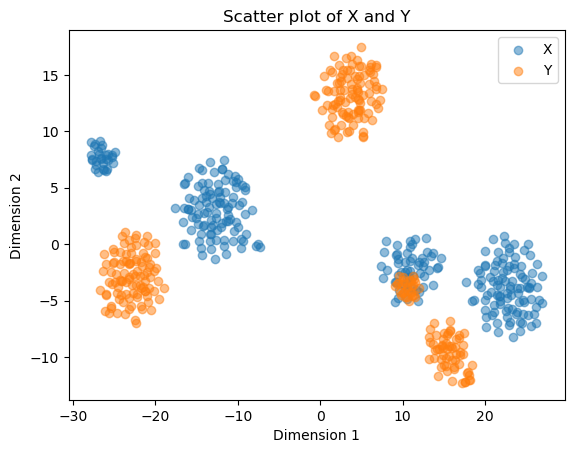

In [101]:
from sklearn.manifold import TSNE

X, Y = create_aligned_dataset(
    n_dim=20,
    n_items=[100, 100, 30, 50, 10],
    mu1=np.random.permutation([0, 1, 2, 3, 4]),
    sigma1=[0.2, 0.4, 0.6, 0.8, 1],
    mu2=[0, 1, 2, 3, 4],
    sigma2=[0.2, 0.4, 0.6, 0.8, 1],
    noise=[0.02, 0.04, 0.06, 0.08, .1]
)

tsne = TSNE(2)
X_tsne = tsne.fit_transform(X)
Y_tsne = tsne.fit_transform(Y)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], label='X', alpha=0.5)
plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], label='Y', alpha=0.5)
plt.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter plot of X and Y')
plt.show()

Insights on K:

* NNGS allows changing $k$ to analyze transformations at different scales
* It is a bit hard to do that with $\sigma$ in CKA-RBF because the "good" value depends on the intra- and inter-cluster distances, which can change with linear transformations.
* With NNGS we can find a good value for $k$ by inspecting the dataset with e.g. TSNE, and choosing what scale we are trying to analyze

However:
* NNGS depends on a "good" value for $k$. The same value for $k$ means different things in different datasets.
* Linear CKA does not depend on any parameter (although - "Linear Kernel" is an implicit parameter by itself)

Usefulness:
* NNGS can be used to detect similarities in multimodal embeddings
* NNGS with a correct $k$ can be more correlated to the zero-shot accuracy than CKA

Theoretical advantages over CKA:
* Resilient to unbalanced blobs
* Can be tuned to the "scale" at which we want to analyze the data

### Writing proposal

Main point: NNGS has additional properties which can be useful to measure similarity in paired spaces; more effective than CKA in some situations


* Experiments demonstrating base properties (like invariance to dimensionality increase)
* Experiments comparing with CKA in toy dataset
* Comparison with CKA in the CLIP dataset (do we need the GloVe experiment?)